In [1]:
import os
import time

import numpy as np
import tensorflow as tf
from joblib import load
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier 
from scipy.stats import reciprocal
import matplotlib.pyplot as plt

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

os.chdir("/Users/quyen/PycharmProjects/Meteo_australie")

def plot_train_validation(epochs, train_loss_values, validation_loss_values,
                          train_acc_values, validation_acc_values):
    fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=2)
    ax[0].plot(epochs, train_loss_values, color="green", label='Training loss')
    ax[0].plot(epochs, validation_loss_values, color="red", label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc_values, color="blue", label='Training acc')
    ax[1].plot(epochs, validation_acc_values, color="violet", label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    return fig


def plot_train_validation_bis(epochs, train_loss_values, validation_loss_values,
                              train_acc_values, validation_acc_values):
    fig = plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_loss_values, color="green", label='Training loss')
    plt.plot(epochs, validation_loss_values, color="red", label='Validation loss')
    
    plt.plot(epochs, train_acc_values, color="blue", label='Training acc')
    plt.plot(epochs, validation_acc_values, color="violet", label='Validation acc')
    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return fig


def build_model(n_layers = 1, n_neurons = 30, learning_rate = 1e-3, input_shape = 65, 
                activation_inter_layers = "relu", metrics = "accuracy"):
    """
    Cette fonction sert à construire et compiler un modèle Keras avec les hyperparamètres donnés
    """
    model = Sequential()
    model.add(Dense(units=n_neurons, activation=activation_inter_layers, input_shape=(input_shape, )))
    if n_layers > 1:
        for layer in range(n_layers - 1):
            model.add(Dense(units=n_neurons, activation="relu"))
    # Ajout d'un layer output
    model.add(Dense(units=1, activation="sigmoid"))    
    
    # Compile du modèle
    adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=metrics)
    
    return model


def build_model_one_layer(n_neurons, learning_rate, activation_inter_layers = "relu", 
                          metrics="accuracy", input_shape=65):
    model = Sequential()
    model.add(Dense(units=n_neurons, activation=activation_inter_layers, input_shape=(input_shape,)))
    model.add(Dense(units=1, activation="sigmoid"))

    # Compile du modèle
    adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=metrics)

    return model


In [2]:
k = 4
path_classification = f"./output/classification/knn_impute_{k}"
path_output = os.path.abspath(os.sep.join([path_classification, "DNN"]))
data_file = f"./output/classification/data_original_pre_processing_without_location_knn_imputed_{k}.joblib"

os.makedirs(path_output, exist_ok=True)

X_train, X_test, y_train, y_test = load(data_file)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
classes = ["Rain" if c == "Yes" else "No Rain" for c in label_encoder.classes_]

n_var_expl = X_train.shape[1]

# Réseaux de neuronnes avec 1 couche

## Test 1

2023-12-05 10:24:39.850543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-05 10:24:39.850588: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-05 10:24:39.850598: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-05 10:24:39.850947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 10:24:39.851439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-05 10:24:40.365697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-05 10:24:40.386148: E te

temps =  2611.56670999527


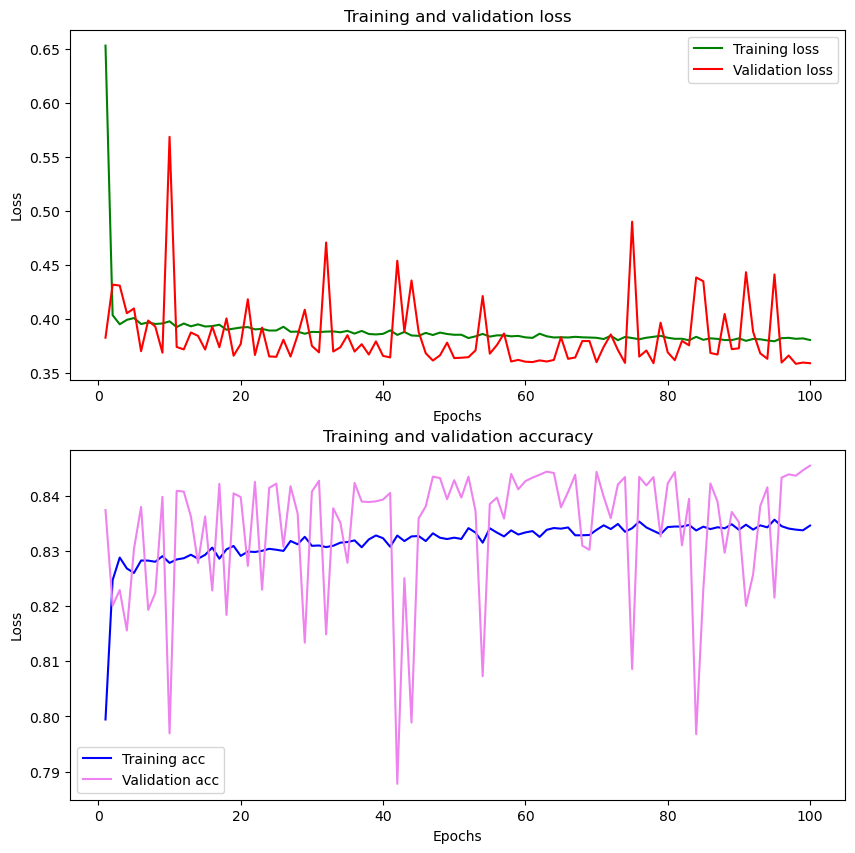

889/889 [==============================] - 3s 3ms/step - loss: 0.3592 - accuracy: 0.8455
[0.35924872756004333, 0.8454938530921936]


In [3]:
lr = 1e-4
n_neurons = 64
activation = "relu"

model_1 = build_model_one_layer(n_neurons=n_neurons, learning_rate = lr, activation_inter_layers = activation,
                                metrics="accuracy", input_shape=n_var_expl) 

t1 = time.time()
result_training = model_1.fit(X_train, y_train_encoded,
                              epochs=100, batch_size=32,
                              validation_data=(X_test, y_test_encoded),
                              verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)


result_dict = result_training.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']

fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

result_dict = result_training.history
result_dict

print(model_1.evaluate(X_test, y_test_encoded))

fichier_out = f"{path_output}/model_1.keras"
model_1.save(fichier_out)

2023-12-05 11:16:03.242413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  4156.277991056442


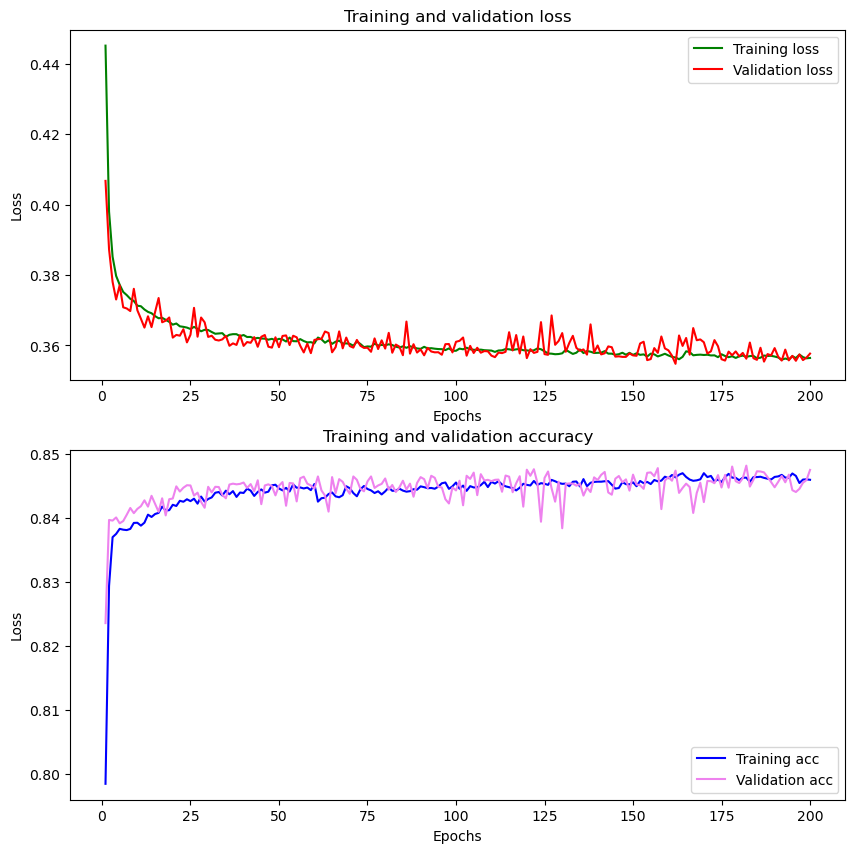

889/889 [==============================] - 4s 5ms/step - loss: 0.3577 - accuracy: 0.8475
[0.3576853275299072, 0.8474981784820557]


In [4]:
lr = 1e-4
n_neurons = 64
activation = "tanh"

model_1b = build_model_one_layer(n_neurons=n_neurons, learning_rate = lr, activation_inter_layers = activation,
                                metrics="accuracy", input_shape=n_var_expl) 

t1 = time.time()
result_training = model_1b.fit(X_train, y_train_encoded,
                              epochs=200, batch_size=32,
                              validation_data=(X_test, y_test_encoded),
                              verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)


result_dict = result_training.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']

fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

result_dict = result_training.history
result_dict

print(model_1b.evaluate(X_test, y_test_encoded))

fichier_out = f"{path_output}/model_1b.keras"
model_1b.save(fichier_out)

## Test 2

2023-12-04 09:08:45.156224: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-04 09:08:45.156281: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-04 09:08:45.156292: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-04 09:08:45.156617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 09:08:45.157117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2023-12-04 09:08:45.894149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-04 09:08:45.923043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


223/223 [==============================] - 3s 10ms/step - loss: 37.6894 - accuracy: 0.6740 - val_loss: 1.8280 - val_accuracy: 0.7842
Epoch 2/200
223/223 [==============================] - 2s 9ms/step - loss: 1.7350 - accuracy: 0.7874 - val_loss: 1.5496 - val_accuracy: 0.7888
Epoch 3/200
223/223 [==============================] - 2s 9ms/step - loss: 1.2895 - accuracy: 0.7964 - val_loss: 1.4804 - val_accuracy: 0.8064
Epoch 4/200
223/223 [==============================] - 2s 9ms/step - loss: 0.6918 - accuracy: 0.8159 - val_loss: 0.5625 - val_accuracy: 0.8098
Epoch 5/200
223/223 [==============================] - 2s 9ms/step - loss: 0.5511 - accuracy: 0.8105 - val_loss: 0.4830 - val_accuracy: 0.8181
Epoch 6/200
223/223 [==============================] - 2s 9ms/step - loss: 0.4851 - accuracy: 0.8111 - val_loss: 0.4451 - val_accuracy: 0.8250
Epoch 7/200
223/223 [==============================] - 2s 9ms/step - loss: 0.4434 - accuracy: 0.8168 - val_loss: 0.4283 - val_accuracy: 0.8261
Epoch 8/2

223/223 [==============================] - 2s 9ms/step - loss: 0.3909 - accuracy: 0.8312 - val_loss: 0.4327 - val_accuracy: 0.8242
Epoch 59/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3928 - accuracy: 0.8299 - val_loss: 0.3665 - val_accuracy: 0.8407
Epoch 60/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3922 - accuracy: 0.8300 - val_loss: 0.3752 - val_accuracy: 0.8405
Epoch 61/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3917 - accuracy: 0.8304 - val_loss: 0.3660 - val_accuracy: 0.8428
Epoch 62/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3872 - accuracy: 0.8313 - val_loss: 0.3690 - val_accuracy: 0.8384
Epoch 63/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3972 - accuracy: 0.8290 - val_loss: 0.3662 - val_accuracy: 0.8404
Epoch 64/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3877 - accuracy: 0.8320 - val_loss: 0.4686 - val_accuracy: 0.8163
Epoch

Epoch 115/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3842 - accuracy: 0.8342 - val_loss: 0.3772 - val_accuracy: 0.8401
Epoch 116/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3922 - accuracy: 0.8302 - val_loss: 0.3689 - val_accuracy: 0.8380
Epoch 117/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3800 - accuracy: 0.8350 - val_loss: 0.3651 - val_accuracy: 0.8405
Epoch 118/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3858 - accuracy: 0.8322 - val_loss: 0.3614 - val_accuracy: 0.8443
Epoch 119/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3864 - accuracy: 0.8317 - val_loss: 0.3718 - val_accuracy: 0.8392
Epoch 120/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3880 - accuracy: 0.8308 - val_loss: 0.3638 - val_accuracy: 0.8446
Epoch 121/200
223/223 [==============================] - 2s 9ms/step - loss: 0.3807 - accuracy: 0.8343 - val_loss: 0.4172 - val_ac

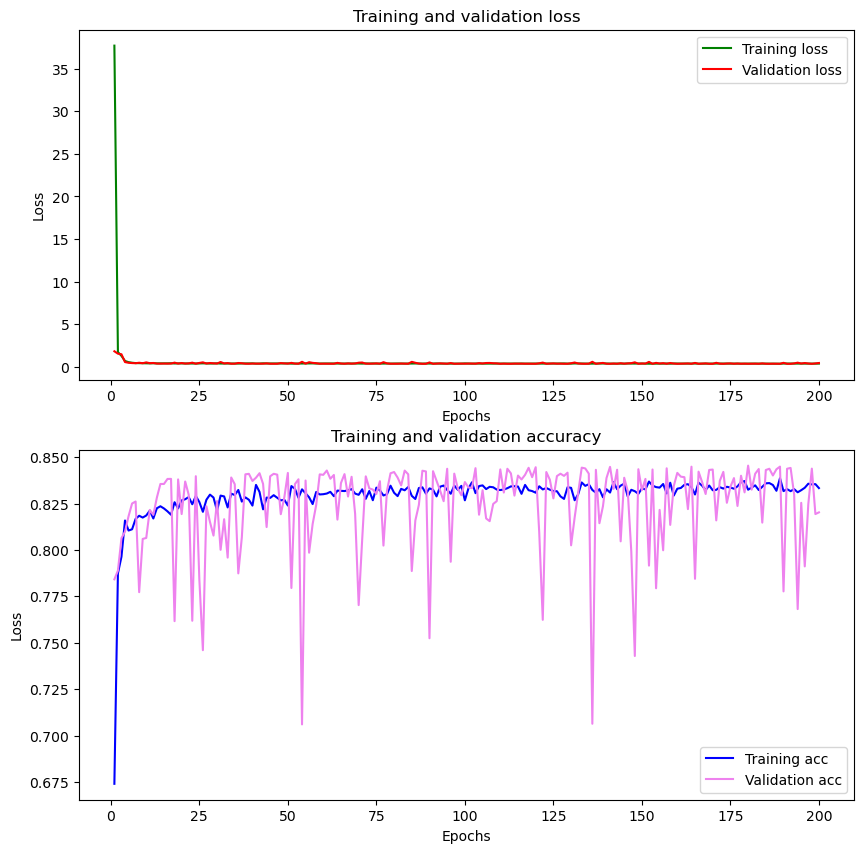

889/889 [==============================] - 5s 5ms/step - loss: 0.4531 - accuracy: 0.8202
[0.4531137943267822, 0.8202468156814575]


In [3]:
    
lr = 1e-3
n_neurons = 16
activation = "relu"

model_2 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_2 = model_2.fit(X_train, y_train_encoded,
                                epochs=200, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=1)
t2 = time.time()
print("temps = ", t2 - t1)


result_dict = result_training_2.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']

fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_2.evaluate(X_test, y_test_encoded))

## Test 3

Epoch 1/200
  1/223 [..............................] - ETA: 1:21 - loss: 17.5368 - accuracy: 0.7969

2023-12-04 09:38:30.633142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


223/223 [==============================] - 2s 8ms/step - loss: 1.8873 - accuracy: 0.7341 - val_loss: 0.5658 - val_accuracy: 0.8247
Epoch 2/200
223/223 [==============================] - 2s 7ms/step - loss: 0.7534 - accuracy: 0.7795 - val_loss: 0.7536 - val_accuracy: 0.8142
Epoch 3/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6217 - accuracy: 0.7972 - val_loss: 0.4460 - val_accuracy: 0.8343
Epoch 4/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6705 - accuracy: 0.7838 - val_loss: 0.8827 - val_accuracy: 0.6551
Epoch 5/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6260 - accuracy: 0.7983 - val_loss: 1.4249 - val_accuracy: 0.4965
Epoch 6/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6634 - accuracy: 0.7968 - val_loss: 0.4601 - val_accuracy: 0.8065
Epoch 7/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6157 - accuracy: 0.8045 - val_loss: 0.3966 - val_accuracy: 0.8388
Epoch 8/200

223/223 [==============================] - 2s 7ms/step - loss: 0.4087 - accuracy: 0.8260 - val_loss: 0.3644 - val_accuracy: 0.8404
Epoch 59/200
223/223 [==============================] - 2s 7ms/step - loss: 0.5352 - accuracy: 0.8005 - val_loss: 0.7789 - val_accuracy: 0.7930
Epoch 60/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4113 - accuracy: 0.8279 - val_loss: 0.4003 - val_accuracy: 0.8341
Epoch 61/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4238 - accuracy: 0.8206 - val_loss: 0.5120 - val_accuracy: 0.8094
Epoch 62/200
223/223 [==============================] - 2s 7ms/step - loss: 0.5204 - accuracy: 0.8078 - val_loss: 0.6228 - val_accuracy: 0.8088
Epoch 63/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4745 - accuracy: 0.8126 - val_loss: 0.3653 - val_accuracy: 0.8401
Epoch 64/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4016 - accuracy: 0.8264 - val_loss: 0.4997 - val_accuracy: 0.8155
Epoch

Epoch 115/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4147 - accuracy: 0.8280 - val_loss: 0.3753 - val_accuracy: 0.8403
Epoch 116/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4840 - accuracy: 0.8123 - val_loss: 0.3983 - val_accuracy: 0.8413
Epoch 117/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3931 - accuracy: 0.8310 - val_loss: 0.3736 - val_accuracy: 0.8394
Epoch 118/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4122 - accuracy: 0.8250 - val_loss: 0.3647 - val_accuracy: 0.8432
Epoch 119/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3992 - accuracy: 0.8293 - val_loss: 0.4066 - val_accuracy: 0.8318
Epoch 120/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4011 - accuracy: 0.8273 - val_loss: 0.4520 - val_accuracy: 0.8272
Epoch 121/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3998 - accuracy: 0.8277 - val_loss: 0.3649 - val_ac

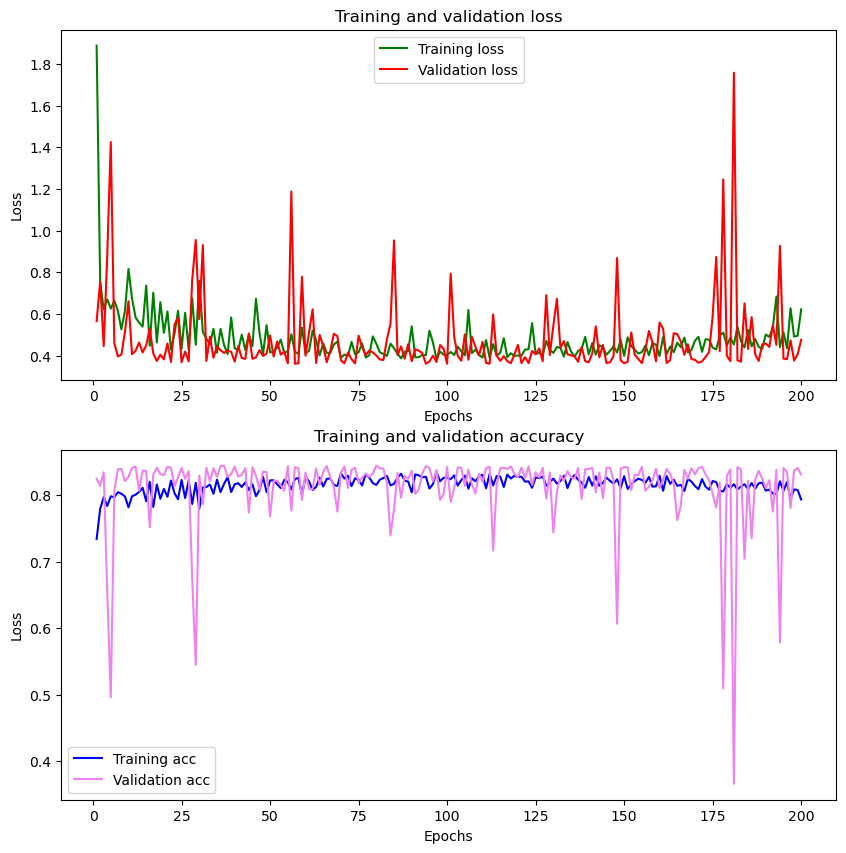

889/889 [==============================] - 3s 4ms/step - loss: 0.4765 - accuracy: 0.8311
[0.47645097970962524, 0.8311473727226257]


In [7]:
    
lr = 1e-3
n_neurons = 64
activation = "relu"

model_3 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_3 = model_3.fit(X_train, y_train_encoded,
                                epochs=200, batch_size=512,
                                validation_data=(X_test, y_test_encoded)
                                )
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_3.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_3.evaluate(X_test, y_test_encoded))

## Test 4
* lr = 1e-4, n_neurons = 64, activation = "relu", epochs = 200, batch_size = 512 

Epoch 1/200
  1/223 [..............................] - ETA: 1:25 - loss: 21.9927 - accuracy: 0.7969

2023-12-04 10:00:44.621733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


223/223 [==============================] - 2s 8ms/step - loss: 2.7190 - accuracy: 0.6653 - val_loss: 1.3245 - val_accuracy: 0.7335
Epoch 2/200
223/223 [==============================] - 2s 7ms/step - loss: 0.9215 - accuracy: 0.7373 - val_loss: 0.6616 - val_accuracy: 0.7936
Epoch 3/200
223/223 [==============================] - 2s 7ms/step - loss: 0.5484 - accuracy: 0.7990 - val_loss: 0.4792 - val_accuracy: 0.8204
Epoch 4/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4650 - accuracy: 0.8183 - val_loss: 0.5061 - val_accuracy: 0.7843
Epoch 5/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4453 - accuracy: 0.8206 - val_loss: 0.4318 - val_accuracy: 0.8320
Epoch 6/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4348 - accuracy: 0.8223 - val_loss: 0.4280 - val_accuracy: 0.8163
Epoch 7/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4167 - accuracy: 0.8263 - val_loss: 0.4006 - val_accuracy: 0.8333
Epoch 8/200

223/223 [==============================] - 2s 7ms/step - loss: 0.3740 - accuracy: 0.8378 - val_loss: 0.3659 - val_accuracy: 0.8426
Epoch 59/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3742 - accuracy: 0.8372 - val_loss: 0.4863 - val_accuracy: 0.7708
Epoch 60/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3699 - accuracy: 0.8393 - val_loss: 0.3585 - val_accuracy: 0.8445
Epoch 61/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3694 - accuracy: 0.8395 - val_loss: 0.3610 - val_accuracy: 0.8433
Epoch 62/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3689 - accuracy: 0.8393 - val_loss: 0.3761 - val_accuracy: 0.8348
Epoch 63/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3725 - accuracy: 0.8380 - val_loss: 0.3858 - val_accuracy: 0.8284
Epoch 64/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3714 - accuracy: 0.8386 - val_loss: 0.3586 - val_accuracy: 0.8445
Epoch

Epoch 115/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3694 - accuracy: 0.8400 - val_loss: 0.3629 - val_accuracy: 0.8428
Epoch 116/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3694 - accuracy: 0.8390 - val_loss: 0.3579 - val_accuracy: 0.8441
Epoch 117/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3706 - accuracy: 0.8392 - val_loss: 0.3621 - val_accuracy: 0.8433
Epoch 118/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3729 - accuracy: 0.8379 - val_loss: 0.3810 - val_accuracy: 0.8300
Epoch 119/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3682 - accuracy: 0.8399 - val_loss: 0.3597 - val_accuracy: 0.8437
Epoch 120/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3669 - accuracy: 0.8410 - val_loss: 0.3586 - val_accuracy: 0.8437
Epoch 121/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3662 - accuracy: 0.8414 - val_loss: 0.4099 - val_ac

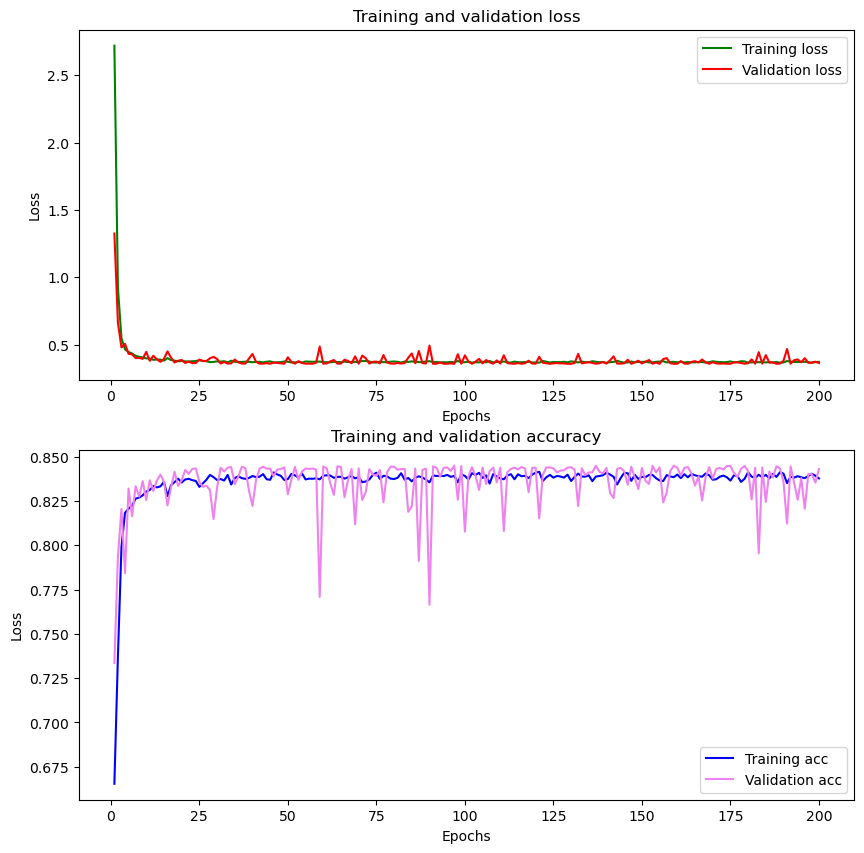

889/889 [==============================] - 3s 4ms/step - loss: 0.3635 - accuracy: 0.8430
[0.36348751187324524, 0.8429621458053589]


In [9]:
    
lr = 1e-4
n_neurons = 64
activation = "relu"

model_4 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_4 = model_4.fit(X_train, y_train_encoded,
                                epochs=200, batch_size=512,
                                validation_data=(X_test, y_test_encoded)
                                )
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_4.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_4.evaluate(X_test, y_test_encoded))

Epoch 1/200
  1/223 [..............................] - ETA: 1:22 - loss: 67.5663 - accuracy: 0.2031

2023-12-04 10:37:41.019949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


223/223 [==============================] - 2s 8ms/step - loss: 4.1053 - accuracy: 0.6212 - val_loss: 1.1094 - val_accuracy: 0.7138
Epoch 2/200
223/223 [==============================] - 2s 7ms/step - loss: 0.8564 - accuracy: 0.7221 - val_loss: 0.7004 - val_accuracy: 0.7654
Epoch 3/200
223/223 [==============================] - 2s 7ms/step - loss: 0.6374 - accuracy: 0.7684 - val_loss: 0.6072 - val_accuracy: 0.7962
Epoch 4/200
223/223 [==============================] - 2s 7ms/step - loss: 0.5499 - accuracy: 0.7881 - val_loss: 0.5108 - val_accuracy: 0.7922
Epoch 5/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4946 - accuracy: 0.7996 - val_loss: 0.4693 - val_accuracy: 0.8140
Epoch 6/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4592 - accuracy: 0.8086 - val_loss: 0.4330 - val_accuracy: 0.8168
Epoch 7/200
223/223 [==============================] - 2s 7ms/step - loss: 0.4336 - accuracy: 0.8169 - val_loss: 0.4140 - val_accuracy: 0.8245
Epoch 8/200

223/223 [==============================] - 2s 7ms/step - loss: 0.3757 - accuracy: 0.8373 - val_loss: 0.3683 - val_accuracy: 0.8412
Epoch 59/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3744 - accuracy: 0.8371 - val_loss: 0.4274 - val_accuracy: 0.8039
Epoch 60/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3698 - accuracy: 0.8393 - val_loss: 0.3599 - val_accuracy: 0.8436
Epoch 61/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3718 - accuracy: 0.8383 - val_loss: 0.3627 - val_accuracy: 0.8428
Epoch 62/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3727 - accuracy: 0.8382 - val_loss: 0.3703 - val_accuracy: 0.8370
Epoch 63/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3748 - accuracy: 0.8375 - val_loss: 0.3869 - val_accuracy: 0.8280
Epoch 64/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3722 - accuracy: 0.8380 - val_loss: 0.3598 - val_accuracy: 0.8435
Epoch

Epoch 115/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3680 - accuracy: 0.8401 - val_loss: 0.3758 - val_accuracy: 0.8377
Epoch 116/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3738 - accuracy: 0.8373 - val_loss: 0.3585 - val_accuracy: 0.8439
Epoch 117/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3721 - accuracy: 0.8386 - val_loss: 0.3738 - val_accuracy: 0.8387
Epoch 118/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3711 - accuracy: 0.8389 - val_loss: 0.4016 - val_accuracy: 0.8196
Epoch 119/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3706 - accuracy: 0.8388 - val_loss: 0.3740 - val_accuracy: 0.8389
Epoch 120/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3697 - accuracy: 0.8398 - val_loss: 0.3592 - val_accuracy: 0.8439
Epoch 121/200
223/223 [==============================] - 2s 7ms/step - loss: 0.3679 - accuracy: 0.8409 - val_loss: 0.4273 - val_ac

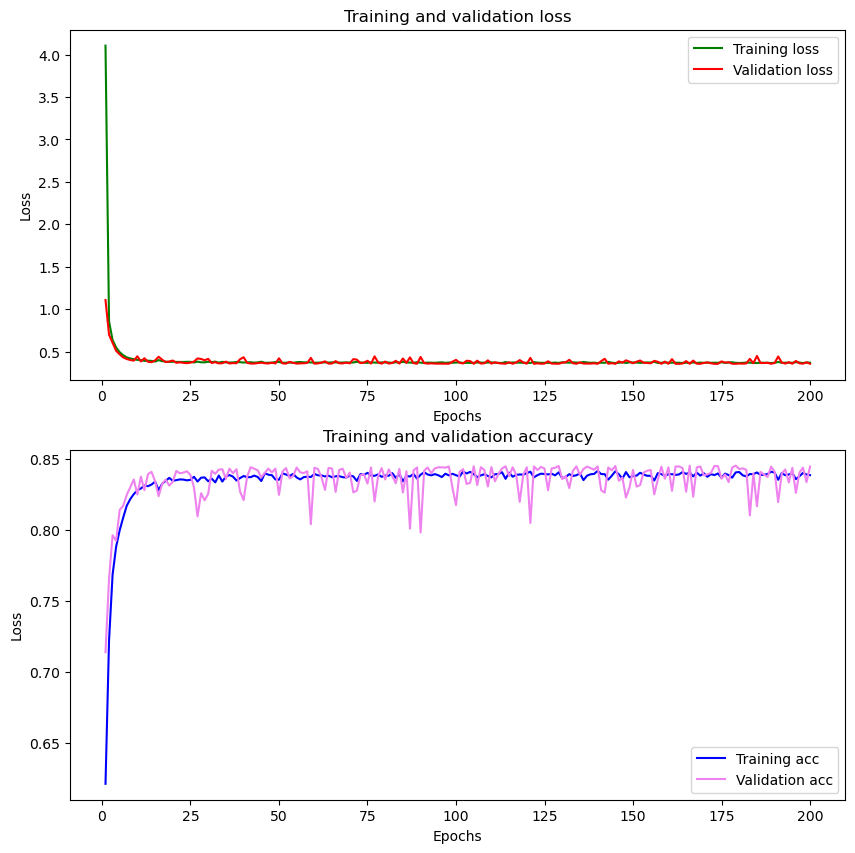

889/889 [==============================] - 3s 4ms/step - loss: 0.3583 - accuracy: 0.8444
[0.35834410786628723, 0.8444389700889587]


In [13]:
    
lr = 1e-4
n_neurons = 64
activation = "relu"

model_4 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_4 = model_4.fit(X_train, y_train_encoded,
                                epochs=200, batch_size=512,
                                validation_data=(X_test, y_test_encoded)
                                )
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_4.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_4.evaluate(X_test, y_test_encoded))

## Test 5
* lr = 1e-4, n_neurons = 64, activation = "relu", epochs = 500, batch_size = 512 

2023-12-04 10:16:58.449742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  702.1238899230957


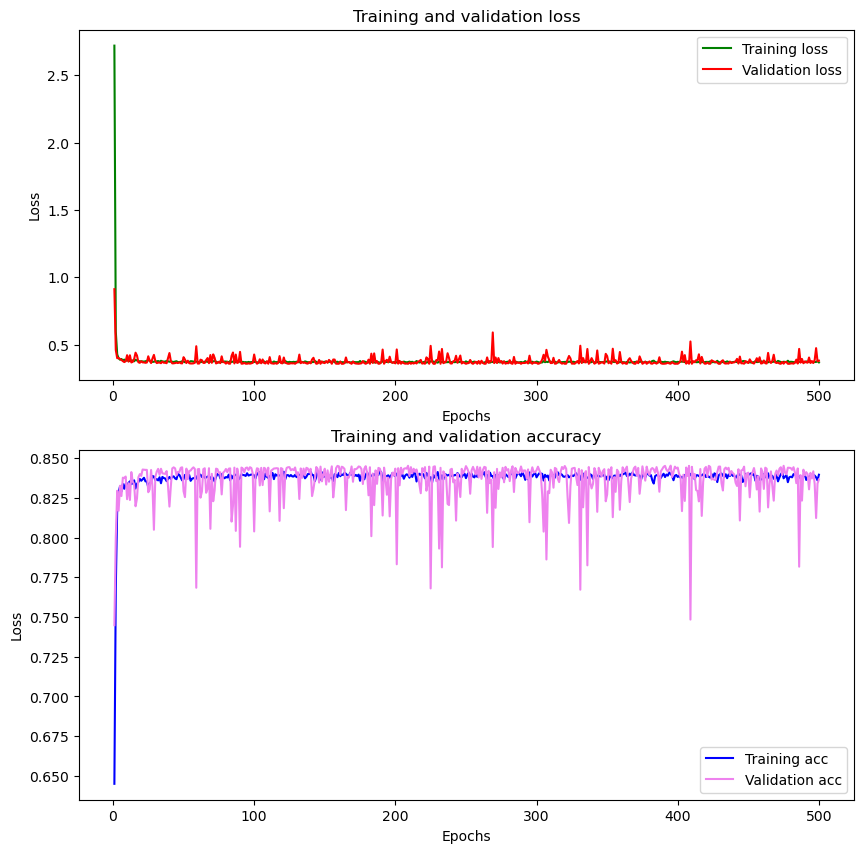

889/889 [==============================] - 3s 4ms/step - loss: 0.3807 - accuracy: 0.8366
[0.38069698214530945, 0.8366327881813049]


In [11]:
    
lr = 1e-4
n_neurons = 64
activation = "relu"

model_5 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_5 = model_5.fit(X_train, y_train_encoded,
                                epochs=500, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_5.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_5.evaluate(X_test, y_test_encoded))

## Test 6
* lr = 1e-4, n_neurons = 64, activation = "tanh", epochs = 200, batch_size = 512

2023-12-04 10:47:14.364716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  285.46793389320374


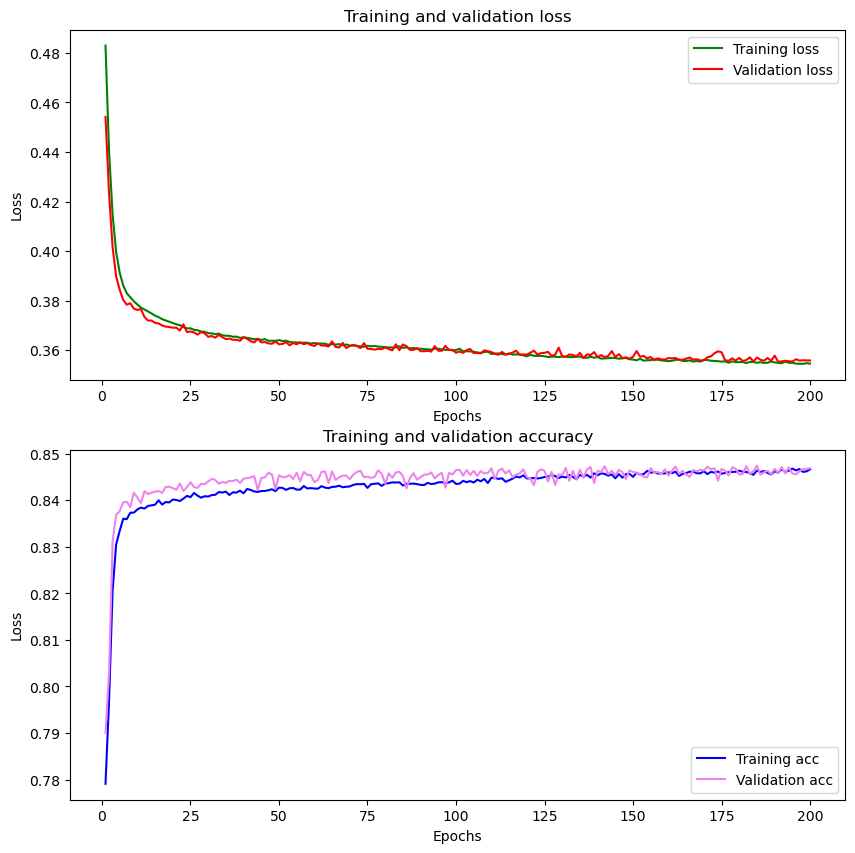

889/889 [==============================] - 4s 4ms/step - loss: 0.3559 - accuracy: 0.8469
[0.3559284508228302, 0.8469004034996033]


In [14]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

lr = 1e-4
n_neurons = 64
activation = "tanh"

model_4 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_4 = model_4.fit(X_train, y_train_encoded,
                                epochs=200, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_4.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_4.evaluate(X_test, y_test_encoded))

2023-12-04 11:17:15.691673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  1009.0449583530426


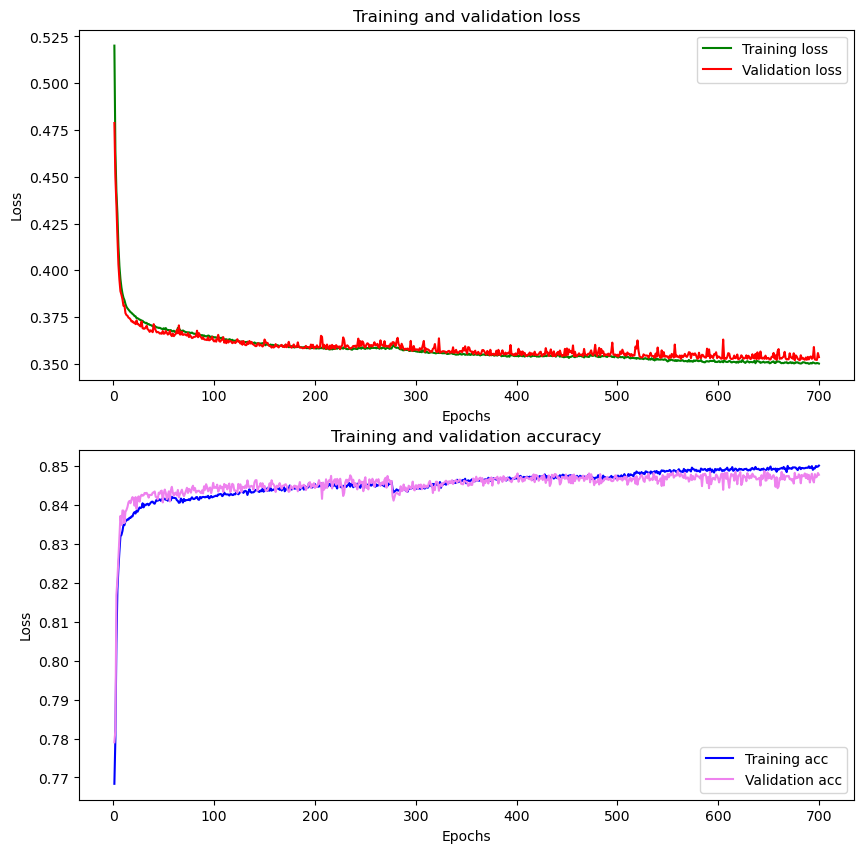

889/889 [==============================] - 3s 4ms/step - loss: 0.3537 - accuracy: 0.8478
[0.3536551296710968, 0.8478146195411682]


In [17]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

lr = 1e-4
n_neurons = 64
activation = "tanh"

model_4 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_4 = model_4.fit(X_train, y_train_encoded,
                                epochs=700, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_4.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_4.evaluate(X_test, y_test_encoded))

In [22]:
os.getcwd()
path_output = "./output/classification/knn_impute_4/DNN"

fichier_out = f"{path_output}/model_4_tanh_700.h5"
model_4.save(fichier_out)

fichier_out = f"{path_output}/model_5_relu_500.h5"
model_5.save(fichier_out)

## Test 7
* lr = 1e-4, n_neurons = 50, activation = "tanh", epochs = 500, batch_size = 128

2023-12-04 12:14:03.257673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  4102.755355834961


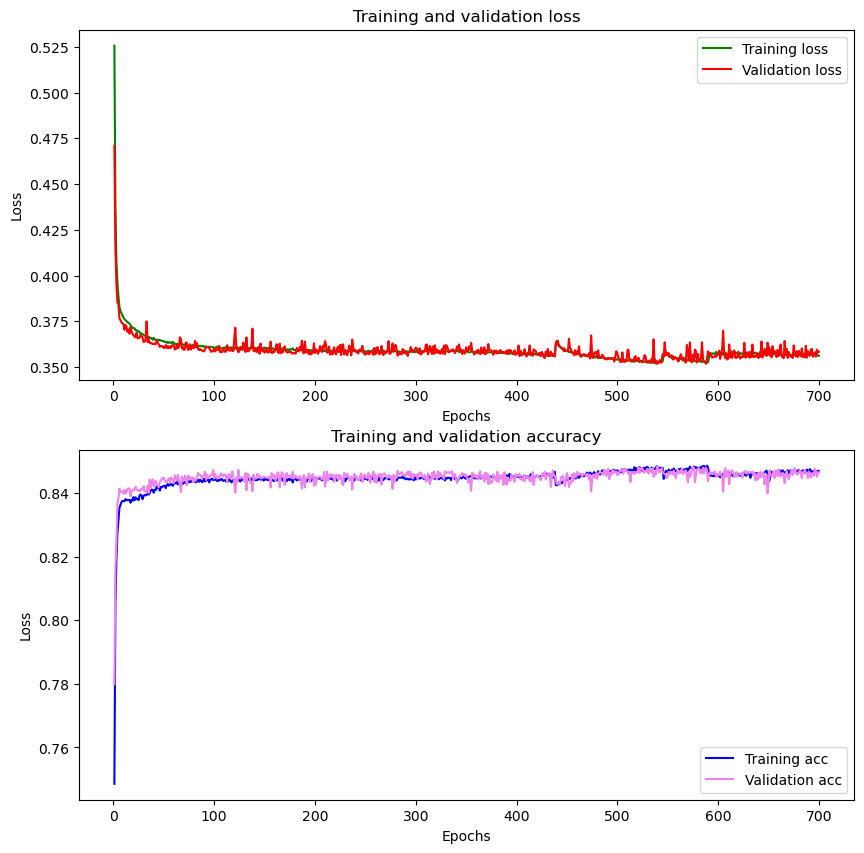

889/889 [==============================] - 3s 4ms/step - loss: 0.3584 - accuracy: 0.8466
[0.35840001702308655, 0.8466190695762634]


In [23]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

lr = 1e-4
n_neurons = 50
activation = "tanh"

model_7 = build_model(n_layers=2, n_neurons=n_neurons, learning_rate=lr, input_shape=n_var_expl,
                      activation_inter_layers = activation, metrics="accuracy") 

t1 = time.time()
result_training_7 = model_7.fit(X_train, y_train_encoded,
                                epochs=700, batch_size=128,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_7.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_7.evaluate(X_test, y_test_encoded))

In [25]:
os.getcwd()
path_output = "./output/classification/knn_impute_4/DNN"

fichier_out = f"{path_output}/model_7.keras"
model_7.save(fichier_out)

## Test 8

2023-12-04 14:28:10.076078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  1630.3802177906036


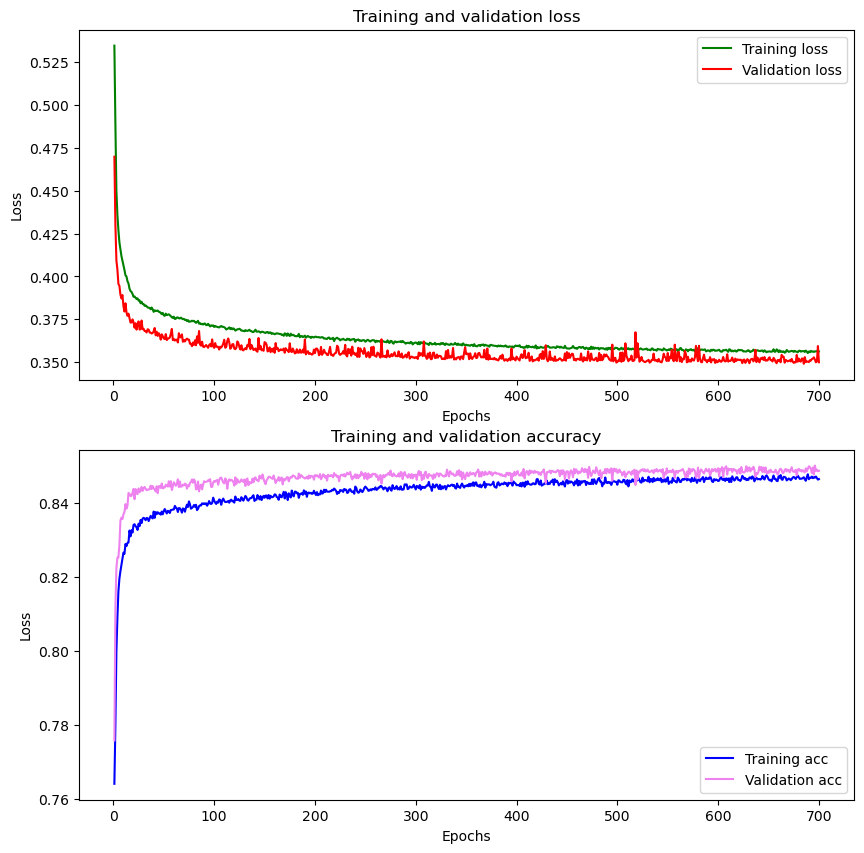

889/889 [==============================] - 3s 4ms/step - loss: 0.3500 - accuracy: 0.8487
[0.35002294182777405, 0.8487288355827332]


In [30]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

learning_rate = 1e-4
n_neurons = 64
activation = "tanh"

model_8 = Sequential()
model_8.add(Dense(units=64, activation=activation, input_shape=(n_var_expl, )))
model_8.add(Dropout(rate=0.2))
model_8.add(Dense(units=32, activation=activation))
model_8.add(Dropout(rate=0.2))
# Ajout d'un layer output
model_8.add(Dense(units=1, activation="sigmoid"))    
    
# Compile du modèle
adam = Adam(learning_rate=learning_rate)
model_8.compile(optimizer=adam, loss="binary_crossentropy", metrics="accuracy")



t1 = time.time()
result_training_8 = model_8.fit(X_train, y_train_encoded,
                                epochs=700, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training_8.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_8.evaluate(X_test, y_test_encoded))

In [31]:
fichier_out = f"{path_output}/model_8.keras"
model_8.save(fichier_out)

## Test 9

2023-12-04 15:10:25.803654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-04 15:10:25.827605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  1087.3062620162964


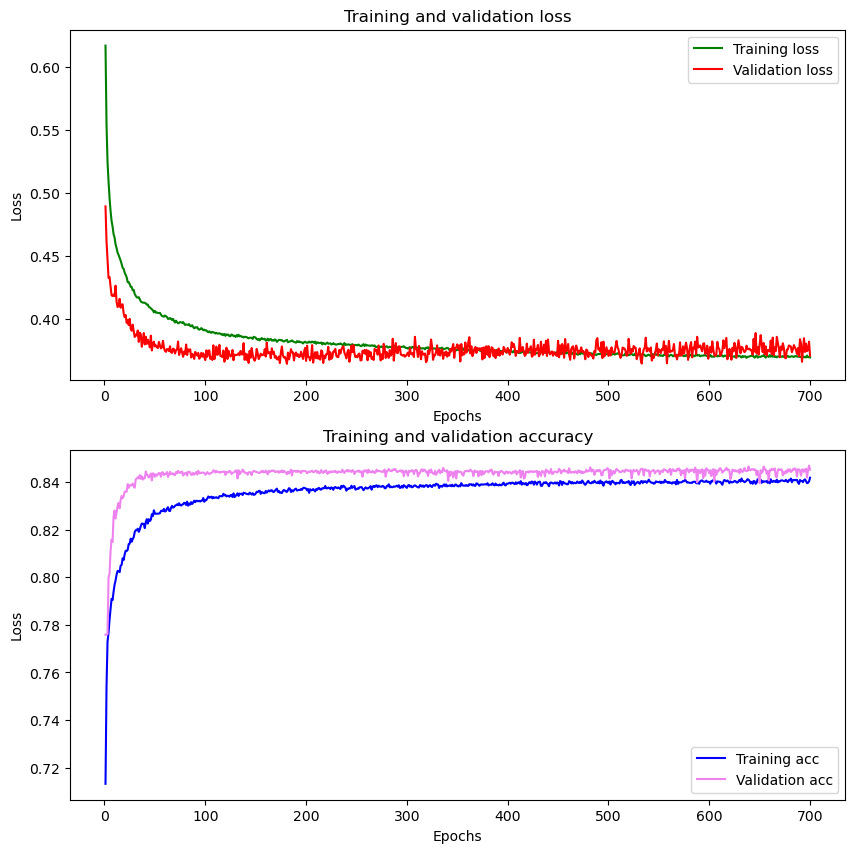

889/889 [==============================] - 3s 4ms/step - loss: 0.3711 - accuracy: 0.8451
[0.37114498019218445, 0.8451422452926636]


In [5]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

learning_rate = 1e-4
n_neurons = 64
activation = "tanh"

model_9 = Sequential()
model_9.add(Dense(units=64, activation=activation, input_shape=(n_var_expl, )))
model_9.add(Dropout(rate=0.5))
model_9.add(Dense(units=32, activation=activation))
model_9.add(Dropout(rate=0.5))
# Ajout d'un layer output
model_9.add(Dense(units=1, activation="sigmoid"))    
    
# Compile du modèle
adam = Adam(learning_rate=learning_rate)
model_9.compile(optimizer=adam, loss="binary_crossentropy", metrics="accuracy")



t1 = time.time()
result_training = model_9.fit(X_train, y_train_encoded,
                                epochs=700, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_9.evaluate(X_test, y_test_encoded))

fichier_out = f"{path_output}/model_9.keras"
model_9.save(fichier_out)

## Test 10

2023-12-04 15:50:44.819557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


temps =  4183.890863895416


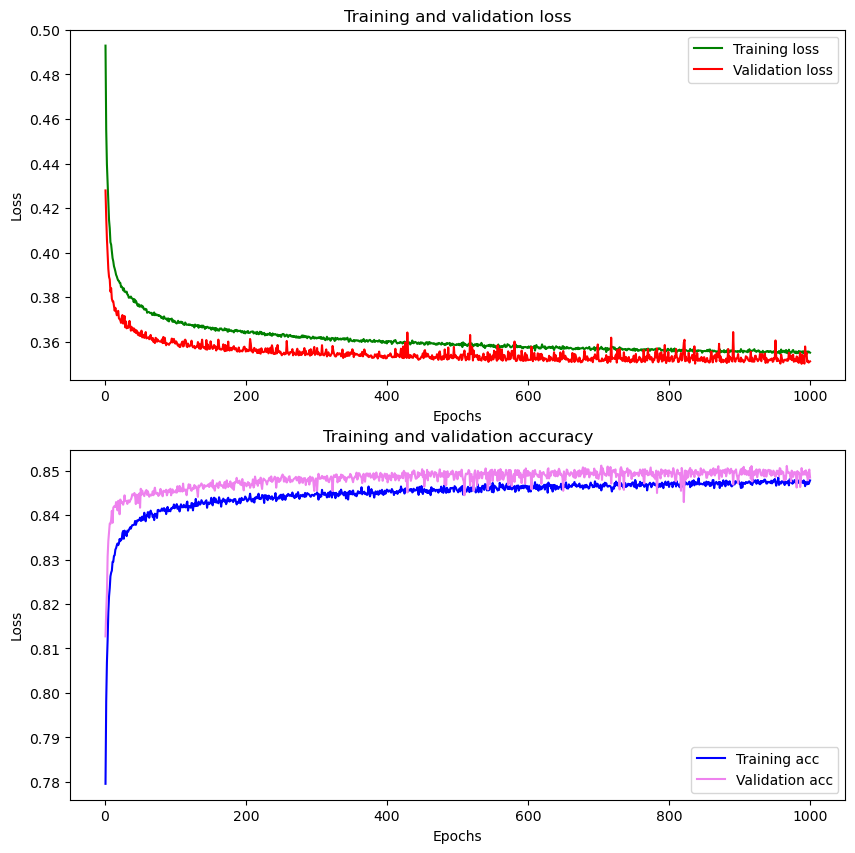

889/889 [==============================] - 3s 4ms/step - loss: 0.3512 - accuracy: 0.8484
[0.351164847612381, 0.8484475612640381]


In [6]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

learning_rate = 1e-4
n_neurons = 64
activation = "tanh"

model_10 = Sequential()
model_10.add(Dense(units=64, activation=activation, input_shape=(n_var_expl, )))
model_10.add(Dropout(rate=0.2))
model_10.add(Dense(units=32, activation=activation))
model_10.add(Dropout(rate=0.2))
model_10.add(Dense(units=1, activation="sigmoid"))    
    
# Compile du modèle
adam = Adam(learning_rate=learning_rate)
model_10.compile(optimizer=adam, loss="binary_crossentropy", metrics="accuracy")



t1 = time.time()
result_training = model_10.fit(X_train, y_train_encoded,
                                epochs=1000, batch_size=512,
                                validation_data=(X_test, y_test_encoded),
                                verbose=0)
t2 = time.time()
print("temps = ", t2 - t1)

result_dict = result_training.history
train_loss_values = result_dict['loss']
validation_loss_values = result_dict['val_loss']
epochs = range(1, len(train_loss_values) + 1)

train_acc_values = result_dict['accuracy'] 
validation_acc_values = result_dict['val_accuracy']


fig = plot_train_validation(epochs, train_loss_values, validation_loss_values,
                            train_acc_values, validation_acc_values)
plt.show()

print(model_10.evaluate(X_test, y_test_encoded))

fichier_out = f"{path_output}/model_10.keras"
model_10.save(fichier_out)

In [5]:
4200/60

70.0